In [1]:
#Librerias necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

##Carga de Datos

In [2]:
# Cargar el archivo CSV en un DataFrame de pandas
data = pd.read_csv('datos.csv', sep=',')
data['fecha'] = pd.to_datetime(data['fecha'])
data = data.sort_values('fecha')
data.set_index('fecha', inplace=True)
data.head()


,prod_id,precio_promedio,ventas,modelo_actual
fecha,,,,
2012-01-01,698,8280.073778,436.0,441.953878
2012-01-01,167,1961.219324,1880.0,1960.518724
2012-01-01,331,4843.074738,819.0,860.015182
2012-01-01,931,12346.697520,1408.0,1351.436692
2012-01-01,530,6194.495105,1540.0,1522.800893


# Depuración de Datos

In [3]:
data.columns

Index(['prod_id', 'precio_promedio', 'ventas', 'modelo_actual'], dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80748 entries, 2012-01-01 to 2023-12-01
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   prod_id          80748 non-null  int64  
 1   precio_promedio  80748 non-null  float64
 2   ventas           80748 non-null  float64
 3   modelo_actual    80748 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 3.1 MB


In [5]:
data["prod_id"].nunique()

1000

In [6]:
prod_0 = data[data["prod_id"] == 698]
prod_1 = data[data["prod_id"] == 341]
prod_2 = data[data["prod_id"] == 133]
prod_3 = data[data["prod_id"] == 131]

l_prod = [prod_0, prod_1, prod_2, prod_3]

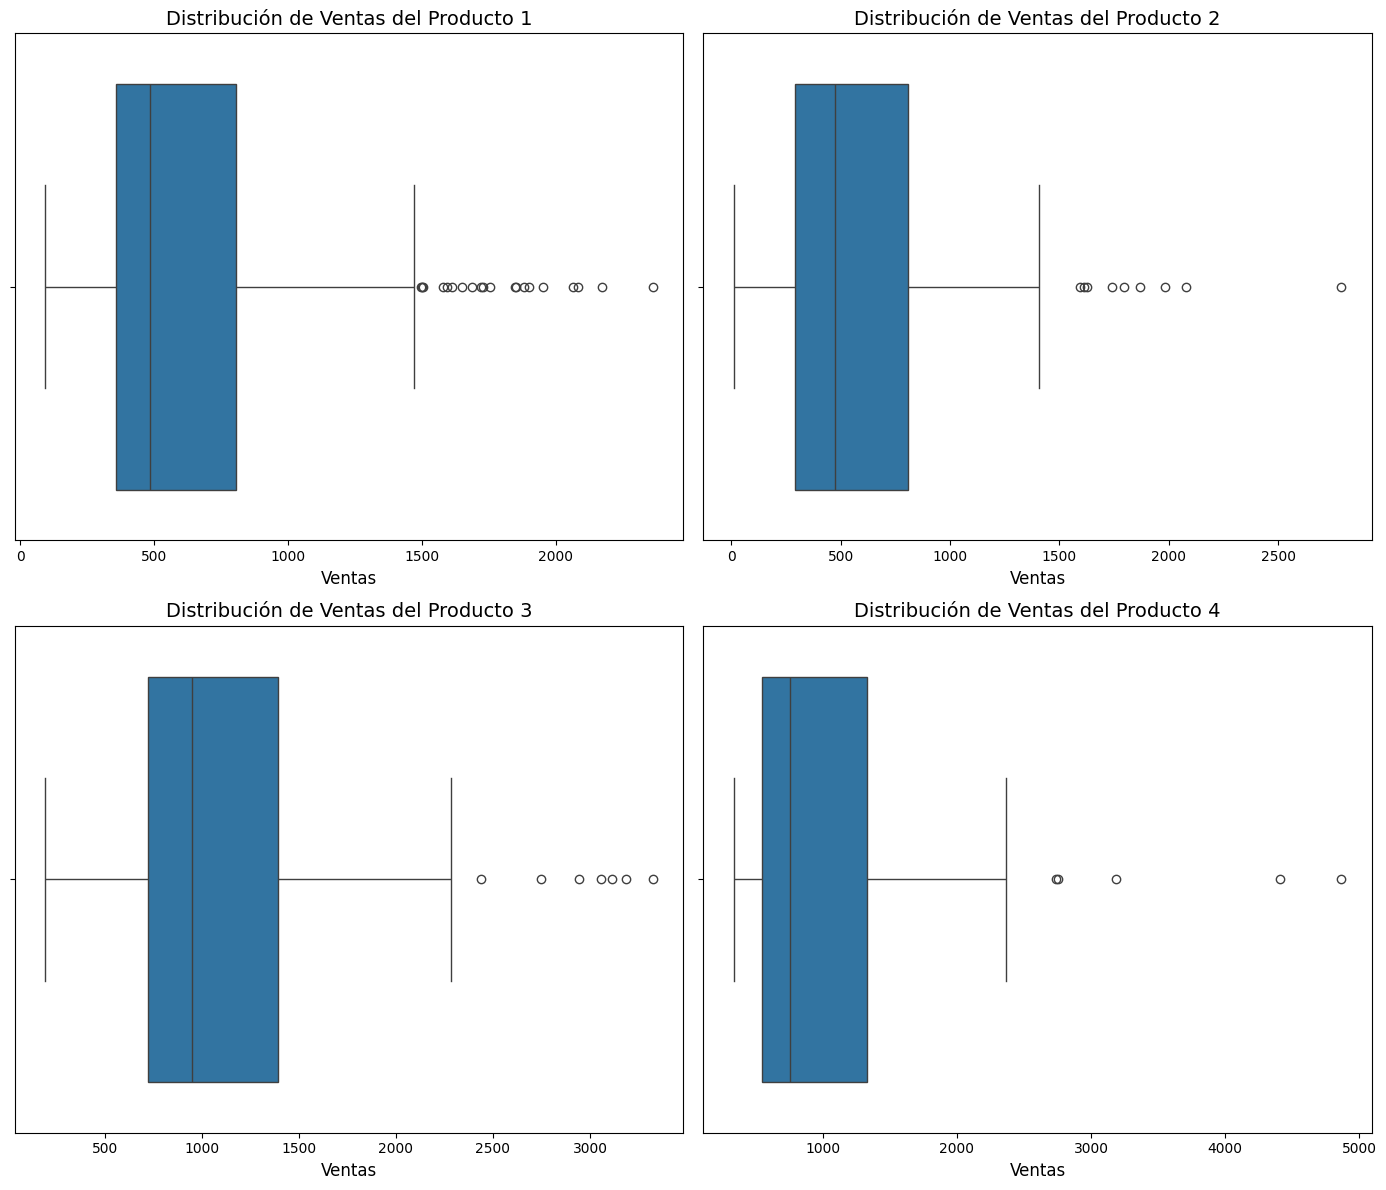

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()
cleaned_data_list  = []
for i, prod in enumerate(l_prod):
    # Obtener datos de ventas para el producto
    prod_ventas = prod["ventas"]
    Q1 = prod_ventas.quantile(0.25)
    Q3 = prod_ventas.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filtrar los datos eliminando los outliers
    data_cleaned = prod[(prod["ventas"] >= lower_bound) & (prod["ventas"] <= upper_bound)].copy()
    cleaned_data_list.append(data_cleaned)

    # Boxplot antes de la limpieza de outliers
    sns.boxplot(x=prod_ventas, ax=axes[i])
    axes[i].set_title(f'Distribución de Ventas del Producto {i+1}', fontsize=14)
    axes[i].set_xlabel('Ventas', fontsize=12)
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].set_ylabel('')


# Ajustar el espaciado entre las gráficas
plt.tight_layout()

plt.show()


# Exploracion de datos


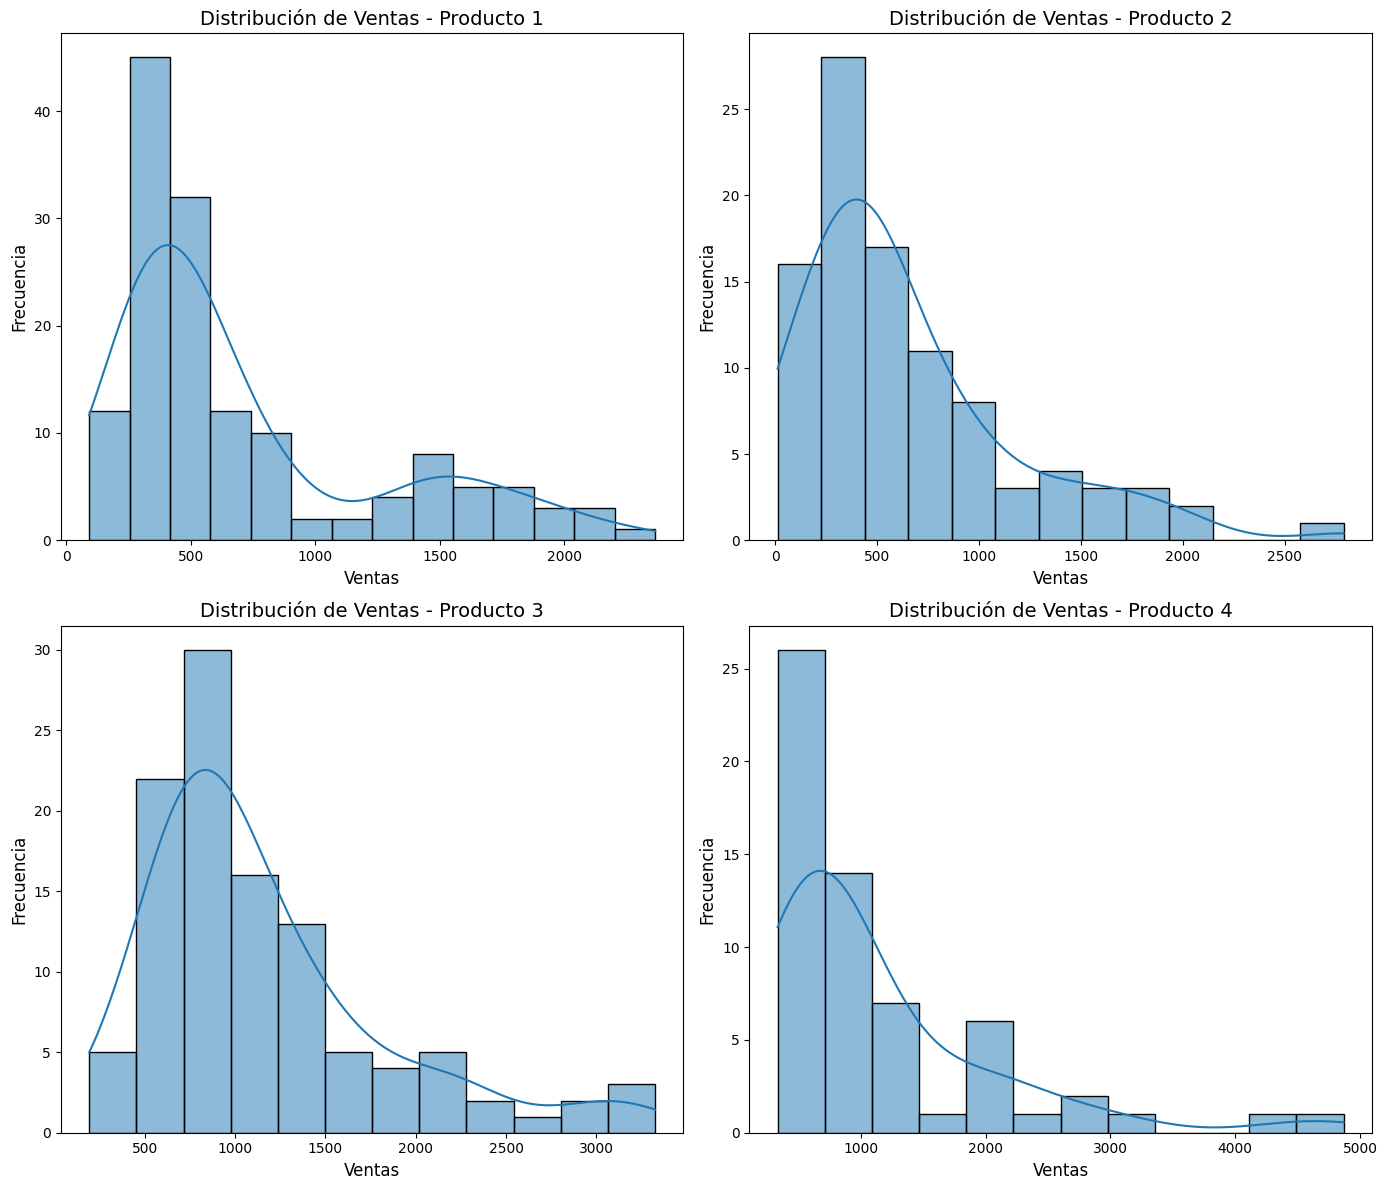

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, prod in enumerate(l_prod):
    # Obtener datos de ventas para el producto
    prod_ventas = prod["ventas"]

    # Histograma y KDE de la variable 'ventas'
    sns.histplot(prod_ventas, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de Ventas - Producto {i+1}', fontsize=14)
    axes[i].set_xlabel('Ventas', fontsize=12)
    axes[i].set_ylabel('Frecuencia', fontsize=12)

# Ajustar el espaciado entre las gráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()

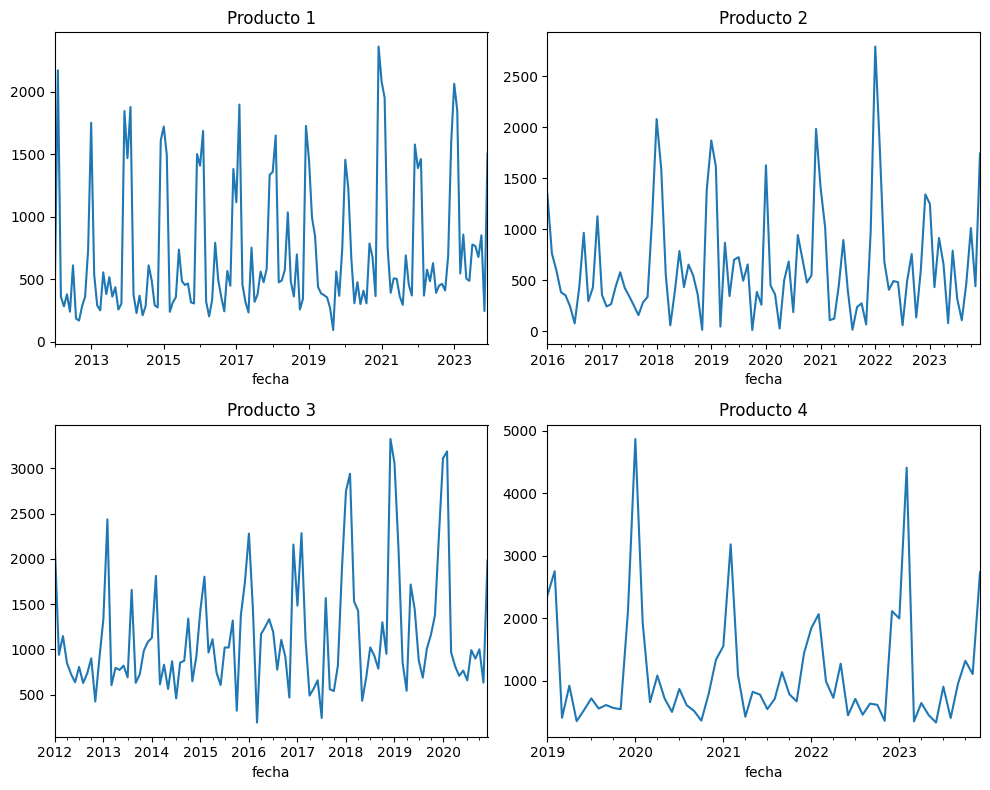

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for i, prod in enumerate(l_prod):
    ax = axs[i]
    prod["ventas"].plot(ax=ax)
    ax.set_title(f'Producto {i+1}')

plt.tight_layout()

plt.show()

In [10]:
# Lista para almacenar los conjuntos de entrenamiento y prueba
train_test_splits = []

for df in l_prod:
    # Dividir en conjunto de prueba y entrenamiento
    test_set = df[-24:]
    train_set = df[:-24]

    # Almacenar los conjuntos en la lista
    train_test_splits.append((train_set, test_set))

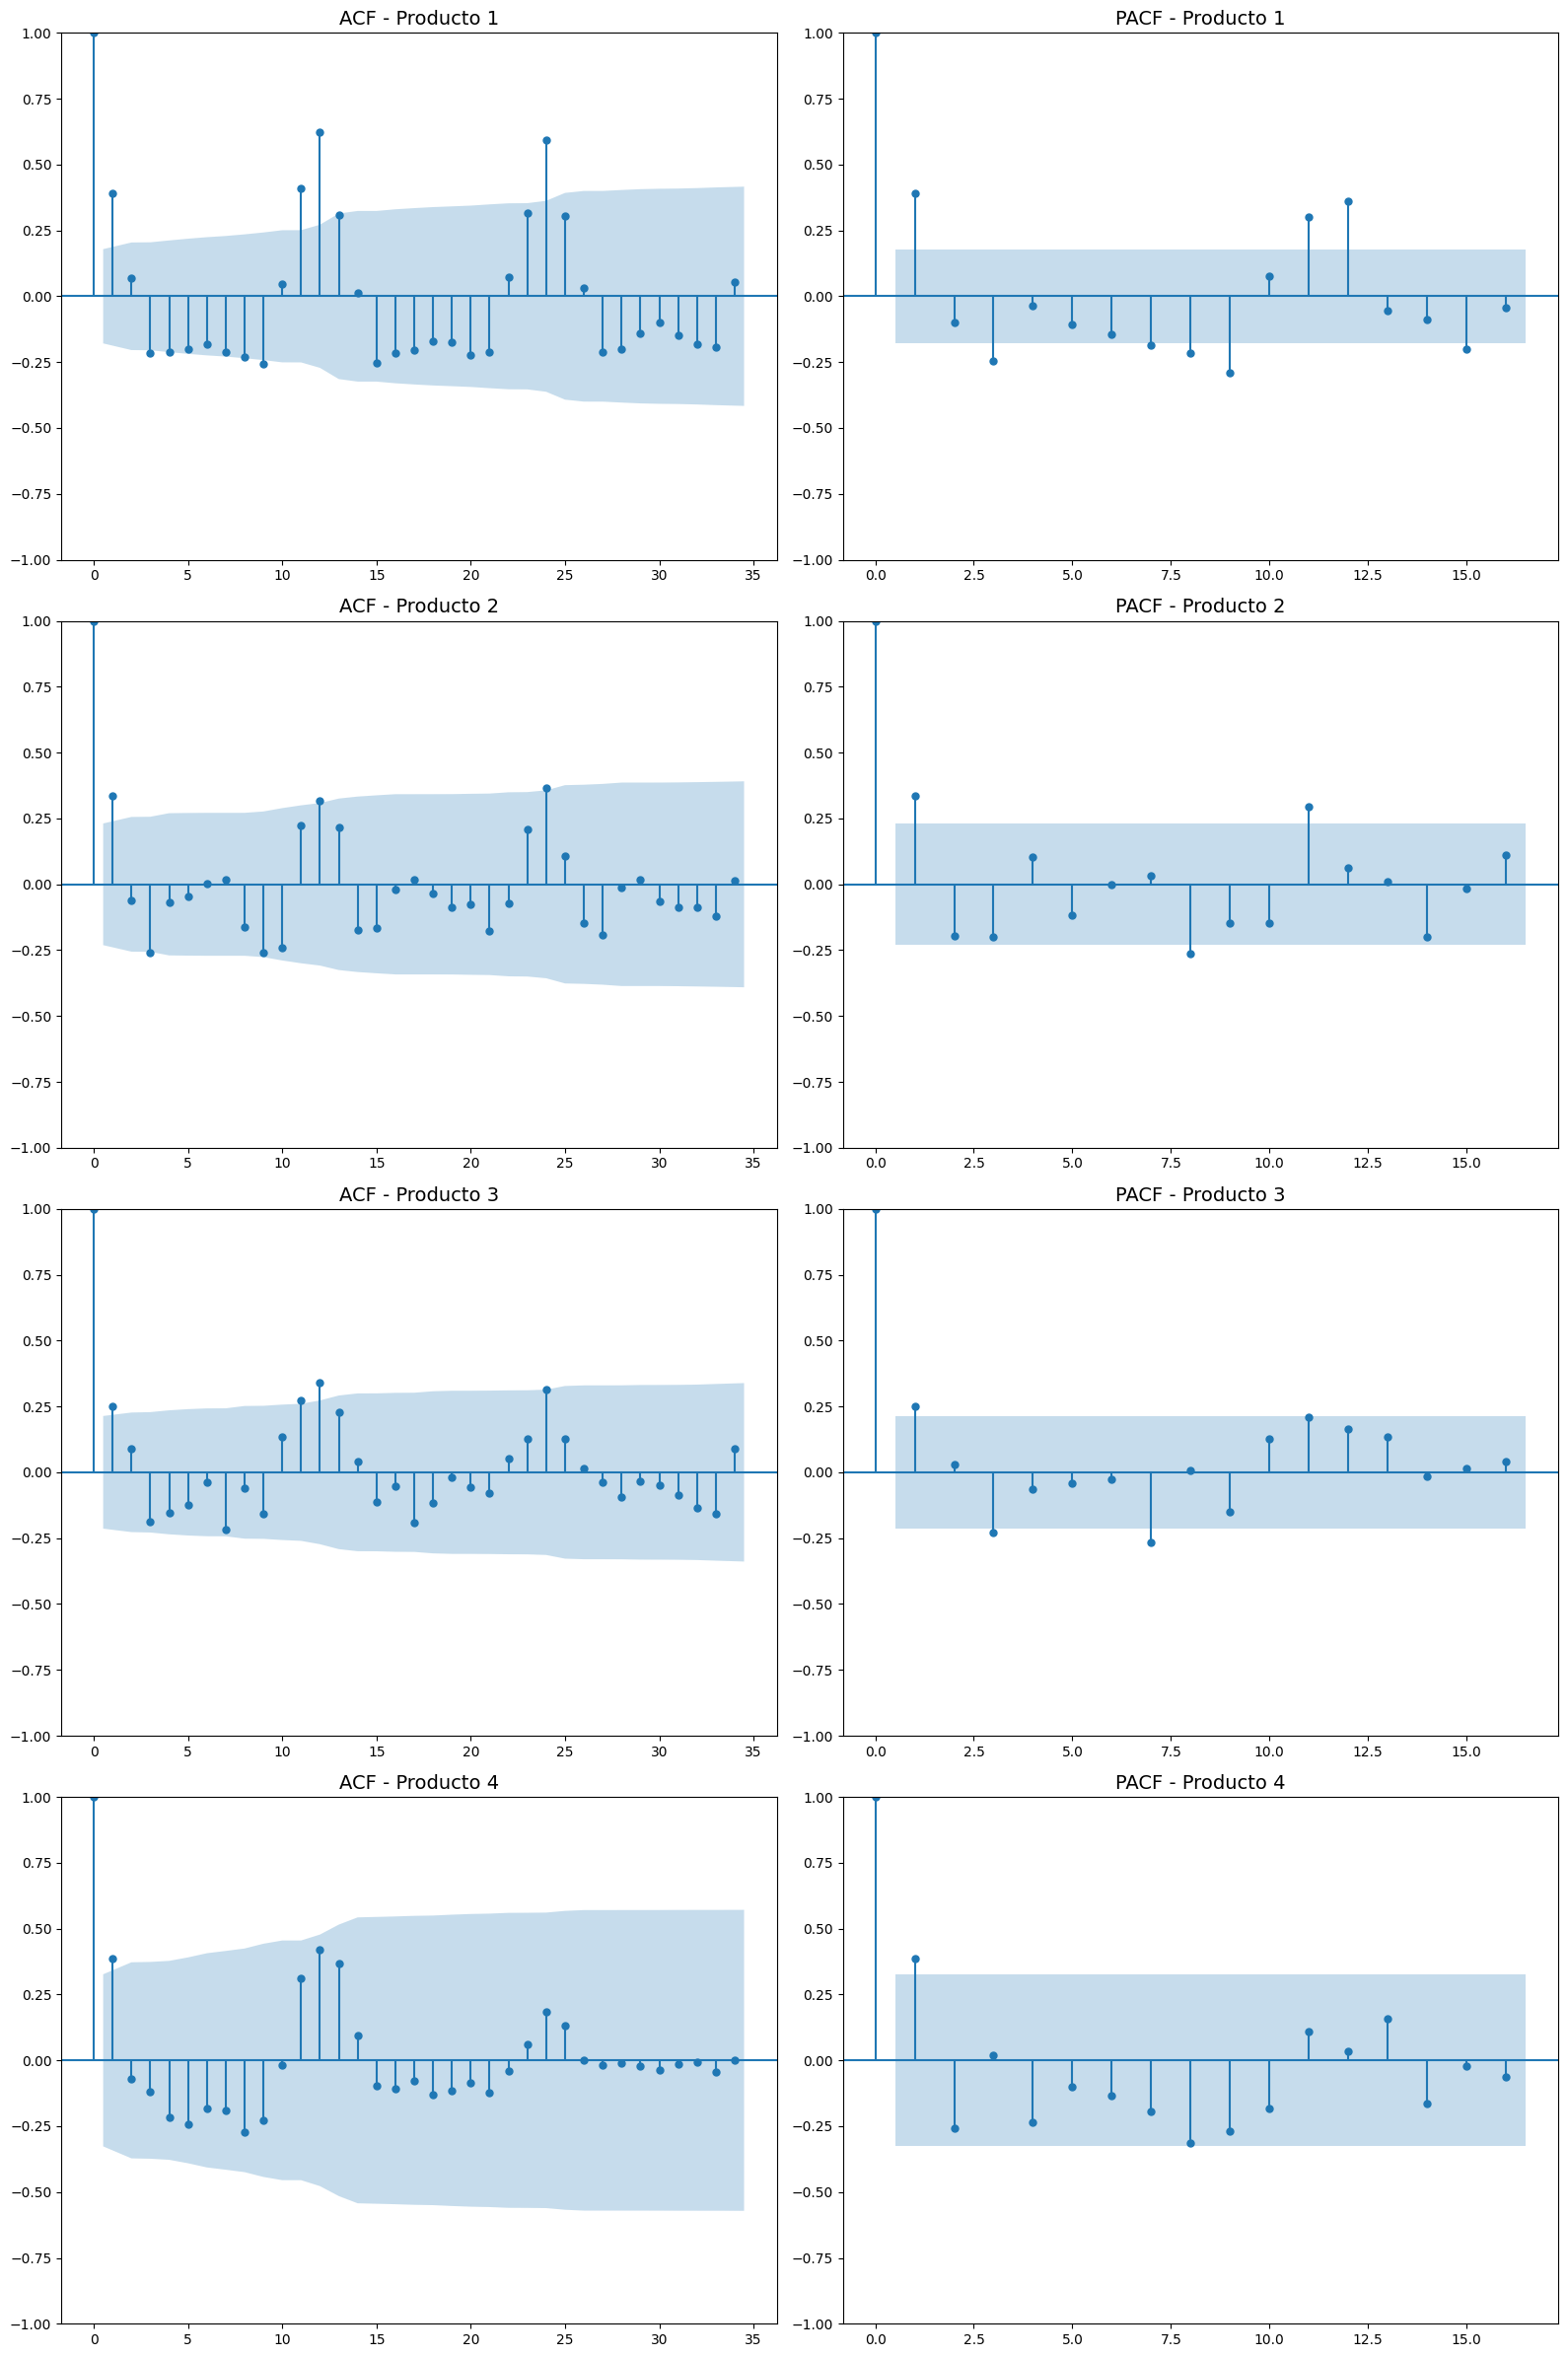

In [11]:
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.flatten()

for i, (train_set, _) in enumerate(train_test_splits):
    # Gráfica ACF para detectar estacionalidad
    ax = axes[2*i]
    plot_acf(train_set['ventas'], lags=34, ax=ax)
    ax.set_title(f'ACF - Producto {i+1}', fontsize=14)

    # Gráfica PACF
    ax = axes[2*i + 1]
    plot_pacf(train_set['ventas'], lags=16, ax=ax)
    ax.set_title(f'PACF - Producto {i+1}', fontsize=14)

# Ajustar el espaciado entre las gráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()


# Modelado de Datos

## Producto 1

In [12]:
#Eleccion del mejor parametro
train = prod_0[:-24]
test = prod_0[-24:]

model = pm.auto_arima(
    train['ventas'],
    start_p=0, start_q=0, max_p=5, max_q=5,  # Para los valores no estacionales
    start_P=0, start_Q=0, max_P=5, max_Q=5,  # Para los valores estacionales
    seasonal=True, m=12,  # 'm' es el número de periodos en una temporada (12 para datos mensuales)
    d=1, D=1,             # Diferenciaciones
    trace=True,           # Muestra el progreso de la búsqueda
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True         # Utiliza un enfoque escalonado para acelerar la búsqueda
)

# Muestra el resumen del modelo seleccionado
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1663.164, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1581.367, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1622.759, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1577.460, Time=0.40 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1577.849, Time=0.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.88 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1613.786, Time=0.28 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1568.502, Time=0.60 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1571.059, Time=0.19 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=1569.329, Time=0.88 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.10 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=i

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47315D+00    |proj g|=  1.04022D-01


/home/clazo/modelo-demanda-agricola/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/clazo/modelo-demanda-agricola/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.45370D+00    |proj g|=  4.90787D-04

At iterate   10    f=  6.45363D+00    |proj g|=  4.15520D-03

At iterate   15    f=  6.44766D+00    |proj g|=  4.47573D-02

At iterate   20    f=  6.44310D+00    |proj g|=  1.79346D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   4.507D-06   6.443D+00
  F =   6.4430977964632437     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MAE: 213.1905648191395
RMSE: 250.49102722512166
MAE modelo actual: 330.0373191726601
RMSE modelo actual: 435.2944138917419


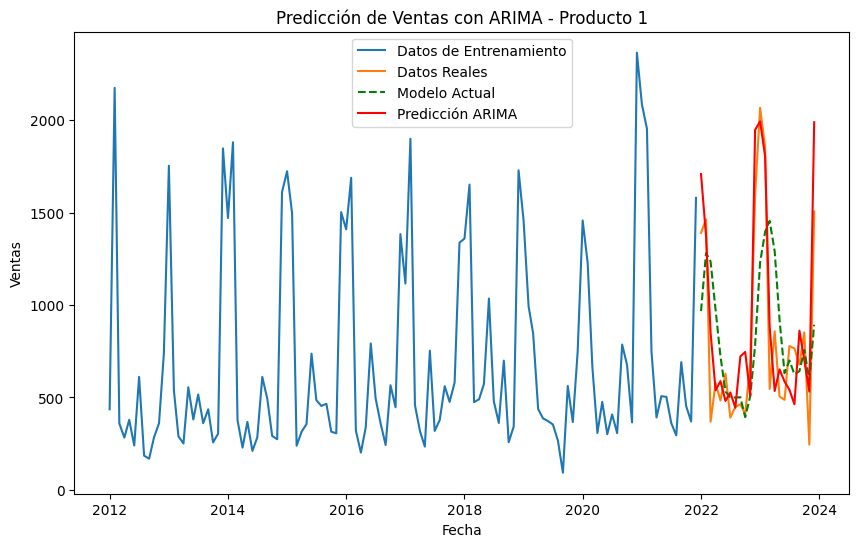

In [13]:
# Modelo ARIMA
train = prod_0[:-24]
test = prod_0[-24:]

model = SARIMAX(train['ventas'], order=(3,1,0), seasonal_order=(2,1,0,12))
model_fit = model.fit()

# Predicción
forecast = model_fit.forecast(steps=24)

# Métricas de error
mae = np.mean(np.abs(forecast - test['ventas']))
rmse = np.sqrt(np.mean((forecast - test['ventas'])**2))
mae_modelo_actual = np.mean(np.abs(test['modelo_actual'] - test['ventas']))
rmse_modelo_actual = np.sqrt(np.mean((test['modelo_actual'] - test['ventas'])**2))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

print(f'MAE modelo actual: {mae_modelo_actual}')
print(f'RMSE modelo actual: {rmse_modelo_actual}')

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['ventas'], label='Datos de Entrenamiento')
plt.plot(test.index, test['ventas'], label='Datos Reales')
plt.plot(test.index, test['modelo_actual'], label='Modelo Actual', color='green', linestyle='--')
plt.plot(test.index, forecast, label='Predicción ARIMA', color='red')
plt.title('Predicción de Ventas con ARIMA - Producto 1')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

## Producto 2

In [14]:
train = prod_1[:-24]
test = prod_1[-24:]

model = pm.auto_arima(
    train['ventas'],
    start_p=0, start_q=0, max_p=5, max_q=5,  # Para los valores no estacionales
    start_P=0, start_Q=0, max_P=5, max_Q=5,  # Para los valores estacionales
    seasonal=True, m=12,  # 'm' es el número de periodos en una temporada (12 para datos mensuales)
    d=1, D=1,             # Diferenciaciones
    trace=True,           # Muestra el progreso de la búsqueda
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True         # Utiliza un enfoque escalonado para acelerar la búsqueda
)

# Muestra el resumen del modelo seleccionado
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=947.449, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=906.860, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=925.186, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=905.132, Time=0.34 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=894.644, Time=0.95 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.55 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.77 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=7.52 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=896.286, Time=2.00 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=inf, Time=3.11 sec
 AR

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30513D+00    |proj g|=  1.21584D-01


/home/clazo/modelo-demanda-agricola/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/clazo/modelo-demanda-agricola/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.24743D+00    |proj g|=  6.48889D-04

At iterate   10    f=  6.24727D+00    |proj g|=  5.68638D-03

At iterate   15    f=  6.23369D+00    |proj g|=  7.87161D-02

At iterate   20    f=  6.16411D+00    |proj g|=  8.26328D-02

At iterate   25    f=  6.14338D+00    |proj g|=  3.93869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     36      1     0     0   1.945D-05   6.143D+00
  F =   6.1433596829451718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MAE: 353.96351288863343
RMSE: 447.7143155938982
MAE modelo actual: 397.81711922503774
RMSE modelo actual: 559.931

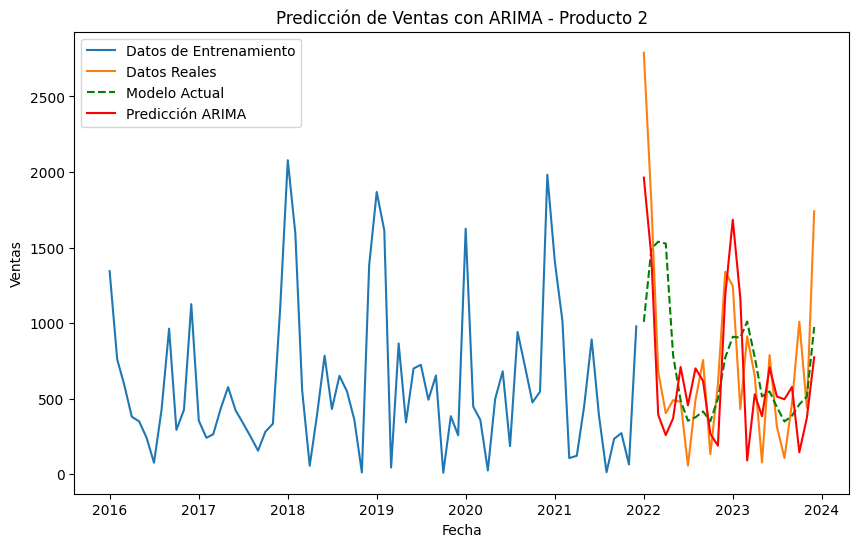

In [15]:
train = prod_1[:-24]
test = prod_1[-24:]

model = SARIMAX(train['ventas'], order=(1,1,0), seasonal_order=(3,1,0,12))
model_fit = model.fit()

# Predicción
forecast = model_fit.forecast(steps=24)

# Métricas de error
mae = np.mean(np.abs(forecast - test['ventas']))
rmse = np.sqrt(np.mean((forecast - test['ventas'])**2))
mae_modelo_actual = np.mean(np.abs(test['modelo_actual'] - test['ventas']))
rmse_modelo_actual = np.sqrt(np.mean((test['modelo_actual'] - test['ventas'])**2))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

print(f'MAE modelo actual: {mae_modelo_actual}')
print(f'RMSE modelo actual: {rmse_modelo_actual}')

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['ventas'], label='Datos de Entrenamiento')
plt.plot(test.index, test['ventas'], label='Datos Reales')
plt.plot(test.index, test['modelo_actual'], label='Modelo Actual', color='green', linestyle='--')
plt.plot(test.index, forecast, label='Predicción ARIMA', color='red')
plt.title('Predicción de Ventas con ARIMA - Producto 2')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

## Producto 3

In [16]:
train = prod_2[:-24]
test = prod_2[-24:]

model = pm.auto_arima(
    train['ventas'],
    start_p=0, start_q=0, max_p=7, max_q=7,  # Para los valores no estacionales
    start_P=0, start_Q=0, max_P=7, max_Q=7,  # Para los valores estacionales
    seasonal=True, m=12,  # 'm' es el número de periodos en una temporada (12 para datos mensuales)
    d=1, D=1,             # Diferenciaciones
    trace=True,           # Muestra el progreso de la búsqueda
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True         # Utiliza un enfoque escalonado para acelerar la búsqueda
)

# Muestra el resumen del modelo seleccionado
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1164.412, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1116.227, Time=0.79 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1141.588, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1115.560, Time=0.60 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1113.162, Time=1.64 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1114.701, Time=4.07 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.93 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1115.365, Time=1.27 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.40 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=1127.377, Time=0.84 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=1113.200, Time=1.27 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=inf, Time=1.53 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=inf, Time=1.72 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=i

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60195D+00    |proj g|=  6.05045D-02


/home/clazo/modelo-demanda-agricola/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/clazo/modelo-demanda-agricola/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.58995D+00    |proj g|=  1.82603D-03

At iterate   10    f=  6.58891D+00    |proj g|=  2.64723D-03

At iterate   15    f=  6.58214D+00    |proj g|=  1.93294D-02

At iterate   20    f=  6.57643D+00    |proj g|=  4.56742D-03

At iterate   25    f=  6.57532D+00    |proj g|=  1.87976D-03

At iterate   30    f=  6.57159D+00    |proj g|=  4.82532D-03

At iterate   35    f=  6.56183D+00    |proj g|=  2.45604D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     54      1     0     0   4.684D-04   6.561D+00
  F =   6.5605121400144686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

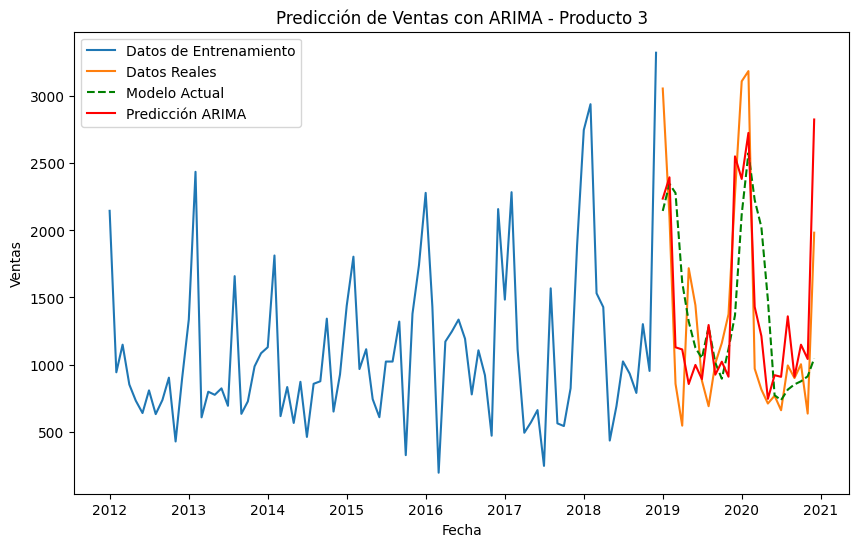

In [17]:
train = prod_2[:-24]
test = prod_2[-24:]

model = SARIMAX(train['ventas'], order=(1,0,1), seasonal_order=(3,1,1,12))
model_fit = model.fit()

# Predicción
forecast = model_fit.forecast(steps=24)

# Métricas de error
mae = np.mean(np.abs(forecast - test['ventas']))
rmse = np.sqrt(np.mean((forecast - test['ventas'])**2))

mae_modelo_actual = np.mean(np.abs(test['modelo_actual'] - test['ventas']))
rmse_modelo_actual = np.sqrt(np.mean((test['modelo_actual'] - test['ventas'])**2))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

print(f'MAE modelo actual: {mae_modelo_actual}')
print(f'RMSE modelo actual: {rmse_modelo_actual}')

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['ventas'], label='Datos de Entrenamiento')
plt.plot(test.index, test['ventas'], label='Datos Reales')
plt.plot(test.index, test['modelo_actual'], label='Modelo Actual', color='green', linestyle='--')
plt.plot(test.index, forecast, label='Predicción ARIMA', color='red')
plt.title('Predicción de Ventas con ARIMA - Producto 3')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

## Producto 4

In [18]:
train = prod_3[:-24]
test = prod_3[-24:]

# Supongamos que `data` es tu serie temporal
model = pm.auto_arima(
    train['ventas'],
    start_p=0, start_q=0, max_p=5, max_q=5,  # Para los valores no estacionales
    start_P=0, start_Q=0, max_P=5, max_Q=5,  # Para los valores estacionales
    seasonal=True, m=12,  # 'm' es el número de periodos en una temporada (12 para datos mensuales)
    d=1, D=1,             # Diferenciaciones
    trace=True,           # Muestra el progreso de la búsqueda
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True         # Utiliza un enfoque escalonado para acelerar la búsqueda
)

# Muestra el resumen del modelo seleccionado
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=400.265, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=397.363, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=391.328, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=391.298, Time=0.16 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(3,1,

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34478D+00    |proj g|=  1.10494D-01

At iterate    5    f=  5.33303D+00    |proj g|=  4.08896D-04

At iterate   10    f=  5.33295D+00    |proj g|=  1.00585D-02

At iterate   15    f=  5.33281D+00    |proj g|=  2.57114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   1.755D-05   5.333D+00
  F =   5.3328108694157006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MAE: 463

/home/clazo/modelo-demanda-agricola/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/clazo/modelo-demanda-agricola/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


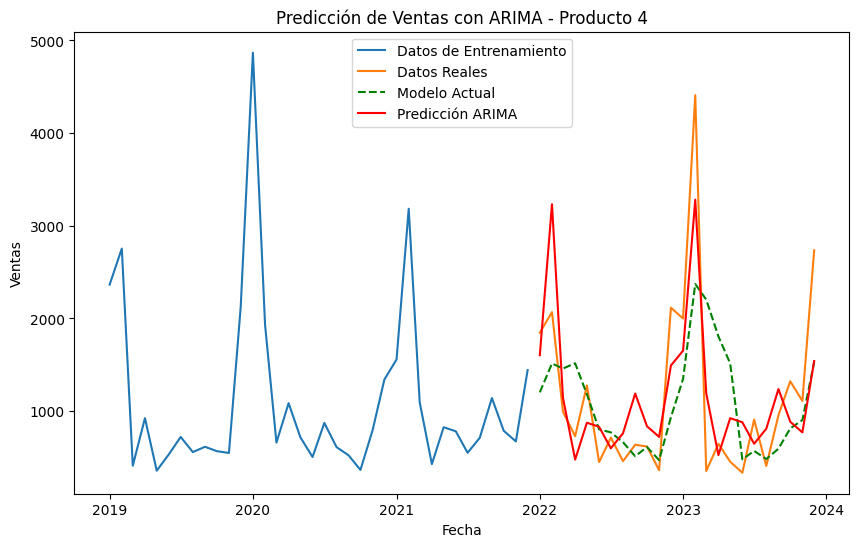

In [19]:
train = prod_3[:-24]
test = prod_3[-24:]

model = SARIMAX(train['ventas'], order=(1,1,1), seasonal_order=(0,1,0,12))
model_fit = model.fit()

# Predicción
forecast = model_fit.forecast(steps=24)

# Métricas de error
mae = np.mean(np.abs(forecast - test['ventas']))
rmse = np.sqrt(np.mean((forecast - test['ventas'])**2))
mae_modelo_actual = np.mean(np.abs(test['modelo_actual'] - test['ventas']))
rmse_modelo_actual = np.sqrt(np.mean((test['modelo_actual'] - test['ventas'])**2))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

print(f'MAE modelo actual: {mae_modelo_actual}')
print(f'RMSE modelo actual: {rmse_modelo_actual}')

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['ventas'], label='Datos de Entrenamiento')
plt.plot(test.index, test['ventas'], label='Datos Reales')
plt.plot(test.index, test['modelo_actual'], label='Modelo Actual', color='green', linestyle='--')
plt.plot(test.index, forecast, label='Predicción ARIMA', color='red')
plt.title('Predicción de Ventas con ARIMA - Producto 4')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()